### Data Exploration and cleaning

In [2]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from tqdm import tqdm

### Change seaborn settings for nicer plots

In [3]:
sns.set(
    style='whitegrid', palette='Set2',
    rc={
        "figure.dpi": 100,
        "axes.spines.top": False,
        "axes.spines.right": False,
    },
)

### Utility Functions

In [4]:
def show_memory_usage():
    size = {var: sys.getsizeof(obj) for var, obj in list(globals().items())}
    size = pd.DataFrame({"label": list(size.keys()), "size": list(size.values())})
    size["sizeMB"] = size['size']/(1024**2)
    return size.sort_values("size", ascending=False).reset_index(drop=True)[["label", "sizeMB"]]
    print(show_memory_usage().head())


def create_data_dict(dataframe, csv_name):
    
    """Extracts and prints a data dictionary to help with extracting and cleaning, needs manual 
    additions for variable descriptions
    
    Parameters
    ----------
    Input: dataframe: a dataframe for which you would like a dictionary
           csv_name: a 'string' which will become part of your csv file name
    
    Output: a dataframe with the variable names and data types. 
    
    Will need to manually enter in addition: data categories, variable descriptions, include (y/n)? and validations"""

    data_dict_cars = pd.DataFrame({
        "variable": list(data.columns),
        "data_type": data.dtypes,
    })
    
    data_dict_cars.to_csv(str('2-' + csv_name + 'data_dict.csv'))
    
    return data_dict_cars 

In [5]:
columns = car_dict.loc[car_dict.eval("category == 'car_type'"), "variable"]

data_cartype = collapse_wide_cols(data, columns, label = "car_type")

NameError: name 'car_dict' is not defined

### People Exploration

In [4]:
data = pd.read_parquet("1-people.parquet", index = 0)

tqdm(ProfileReport(data).to_file("people_report_historical.html"))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Check to see if the id is a unique identifier.

In [5]:
len(data) == len(data['id'].unique()) # returns true or False. Need to inspect duplicates

False

In [6]:
# Select duplicate rows except first occurrence based on all columns
duplicateRowsDF = data[data.duplicated(keep=False)]

it seems there is one duplicated row. Need to remove in order to model properly

In [7]:
data.drop_duplicates(keep='first', inplace=True) # removes duplicates and replaces original dataframe
data.shape # lost one member, we are ok. 

(99, 8)

In [8]:
data.dtypes

id              int64
age             int64
salary          int64
height          int64
family_size     int64
location       object
sex            object
car            object
dtype: object

### Plots

In [ ]:
data.hist(sharex = False, sharey = False, xlabelsize = 1, ylabelsize =1)

# density
data.plot(kind='density', subplots=True, layout=(4,4), sharex=False, legend=False,
fontsize=1)


In [ ]:
# box and whisker plots
data.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False,
fontsize=12)
plt.show()

location
rural    34
urban    65
Name: id, dtype: int64

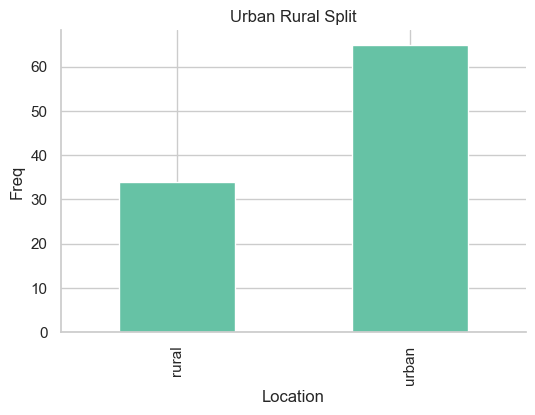

In [11]:
freq = data.groupby("location")['id'].count()
freq.plot(kind="bar", legend=None)
plt.xlabel("Location")
plt.ylabel("Freq")
plt.title("Urban Rural Split")

display(freq)

sex
female    39
male      60
Name: id, dtype: int64

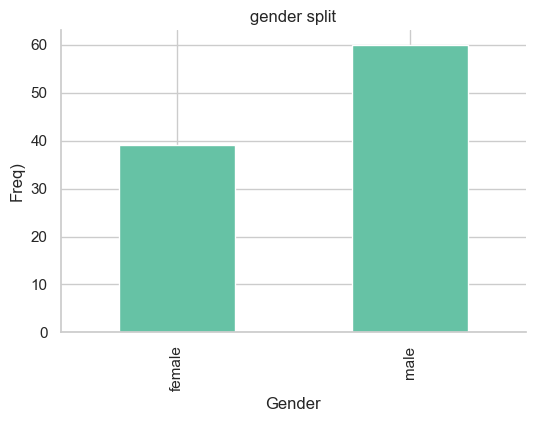

In [12]:
freq = data.groupby("sex")['id'].count()
freq.plot(kind="bar", legend=None)
plt.xlabel("Gender")
plt.ylabel("Freq)")
plt.title("gender split")

display(freq)

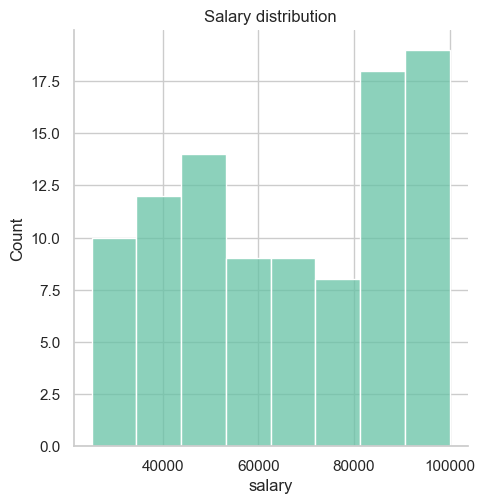

In [13]:
sal = data['salary']
sns.displot(sal).set(title ='Salary distribution')


Are age and income correlated to highly to include on a linear regression

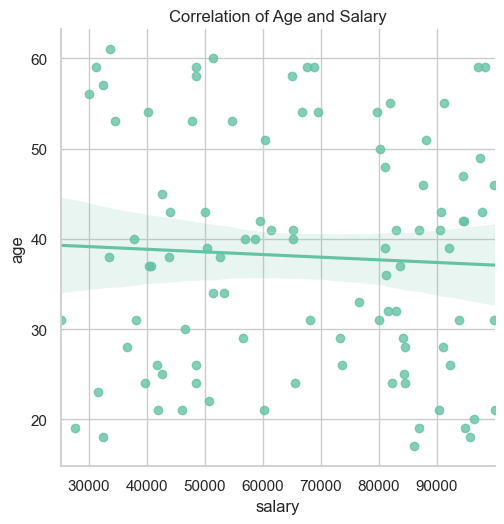

In [14]:
# Show the results of a linear regression within each dataset
sns.lmplot(x="salary", y="age", data=data, palette="muted").set(title = 'Correlation of Age and Salary')

Nope - that is odd but our data is fake so ¯\_(ツ)_/¯

## Car data

In [6]:
data = pd.read_parquet("1-cars.parquet", index = 0)

# ProfileReport(data).to_file("cars_report_historical.html")

car_dict = pd.read_csv('2-data.dict.cars.csv')
data.dtypes

vehicle_name                       object
smallsporty_compactlarge_sedan      int64
sports_car                          int64
suv                                 int64
wagon                               int64
minivan                             int64
pickup                              int64
awd                                 int64
rwd                                 int64
retail_price                        int64
dealer_cost                         int64
engine_size_(l)                   float64
cyl                                 int64
hp                                  int64
city_mpg                          float64
hwy_mpg                           float64
weight                            float64
wheel_base                        float64
len                               float64
width                             float64
dtype: object

In [7]:
data.rename(columns={"smallsporty_compactlarge_sedan": "sedan"}, inplace = True)

## missingness

In [8]:
data.isnull().any().any()

True

<AxesSubplot:>

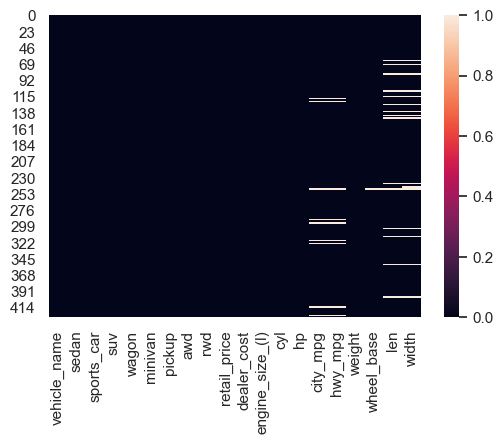

In [9]:
sns.heatmap(data.isnull())

inspection of missing data rows

In [10]:
null_data = data[data.isnull().any(axis=1)]
null_data.head(3)

,vehicle_name,sedan,sports_car,suv,wagon,minivan,pickup,awd,rwd,retail_price,dealer_cost,engine_size_(l),cyl,hp,city_mpg,hwy_mpg,weight,wheel_base,len,width
58,Cadillac Escalade EXT,0,0,0,0,0,1,1,0,52975,48541,6.0,8,345,13.0,17.0,5879.0,130.0,NaN,NaN
64,Chevrolet Avalanche 1500,0,0,0,0,0,1,1,0,36100,31689,5.3,8,295,14.0,18.0,5678.0,130.0,NaN,NaN
70,Chevrolet Colorado Z85,0,0,0,0,0,1,1,0,18760,17070,2.8,4,175,18.0,23.0,3623.0,111.0,NaN,NaN


in order to see the and count the best aparatus for the encoded columns - melt them then analyze then keep or ammend

In [11]:
data.to_parquet('2-renamed_data.parquet')